In [1]:
# Data Process
import pandas as pd
import numpy as np 

# Data visulization
import plotly.express as px
import plotly
import matplotlib.pyplot as plt

# IO
from pathlib import Path

# Feature & Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

# custom function 
from src.data.data_preprocess import *
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)

In [2]:
# read csv data file
home = str(Path.home())
data = pd.read_csv(home + '/Startup-Analysis/data/raw/startup_data.csv')

# only include necessary columns 
col = [c for c in data.columns if c not in ['Unnamed: 0', 'Unnamed: 6', 'state_code.1', 'object_id']]
data = data[col]

## Clean the age feature 
There are negative values in the age feature, which does not make sence, convert them to 0

In [3]:
feat_need_clean = ['age_first_funding_year', 
                  'age_last_funding_year', 
                  'age_first_milestone_year', 
                  'age_last_milestone_year']
for f in feat_need_clean:
    data[f] = np.where(data[f] < 0, 0, data[f])

## Impute missing value 
The feature age_first_milestore_year & age_last_milestore_year have missing values, so we need to impute the missing values

In [4]:
data[['age_first_funding_year', 
                  'age_last_funding_year', 
                  'age_first_milestone_year', 
                  'age_last_milestone_year']].corr(numeric_only = True)

,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year
age_first_funding_year,1.000000,0.755921,0.612176,0.473392
age_last_funding_year,0.755921,1.000000,0.712054,0.642118
age_first_milestone_year,0.612176,0.712054,1.000000,0.787456
age_last_milestone_year,0.473392,0.642118,0.787456,1.000000


Both features are higly correlated with age_last_funding_year and it does not have missing value so we can simply fit a linear regression model on non-missing records and use that model to impute

In [5]:
data_subset = data[(data['age_first_milestone_year'].isna() == False) 
                   & (data['age_last_milestone_year'].isna() == False)][['age_last_funding_year', 
                  'age_first_milestone_year', 
                  'age_last_milestone_year']]

lr1 = LinearRegression()
lr1.fit(data_subset[['age_last_funding_year']], data_subset['age_first_milestone_year'])

lr2 = LinearRegression()
lr2.fit(data_subset[['age_last_funding_year']], data_subset['age_last_milestone_year'])

LinearRegression()

In [6]:
data['age_first_milestone_year_impute'] = np.where(data['age_first_milestone_year'].isna(), 
                                                   lr1.intercept_ + data['age_last_funding_year'] * lr1.coef_[0], 
                                                   data['age_first_milestone_year'])

data['age_last_milestone_year_impute'] = np.where(data['age_last_milestone_year'].isna(), 
                                                   lr2.intercept_ + data['age_last_funding_year'] * lr2.coef_[0], 
                                                   data['age_last_milestone_year'])

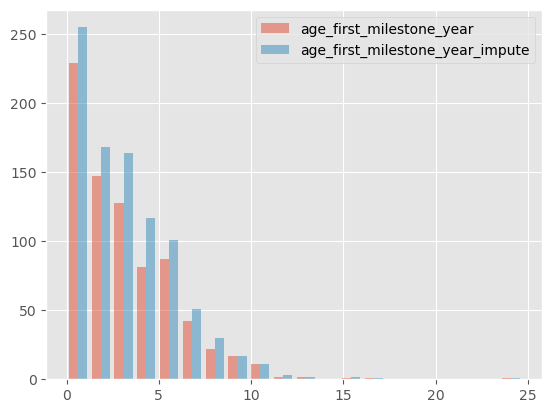

In [7]:
plt.hist([data['age_first_milestone_year'], data['age_first_milestone_year_impute']], 
            bins = 20, alpha=0.5, label=['age_first_milestone_year', 'age_first_milestone_year_impute'])
plt.legend(loc='upper right')
plt.show()

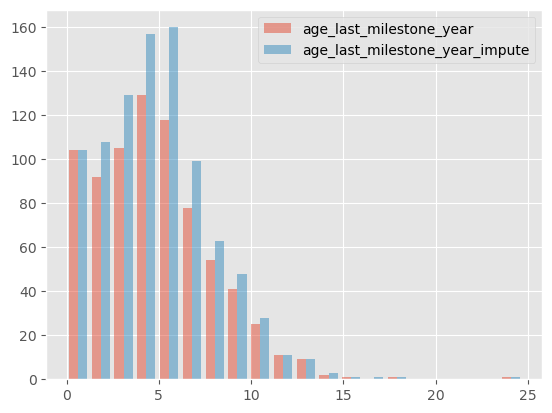

In [8]:
plt.hist([data['age_last_milestone_year'], data['age_last_milestone_year_impute']], 
            bins = 20, alpha=0.5, label=['age_last_milestone_year', 'age_last_milestone_year_impute'])
plt.legend(loc='upper right')
plt.show()

The overall distribution does not change

## Pre-processing location data
The location feature has state, city, lat & long, sometimes if we derive lat & long into decile, it could provide useful info

In [9]:
data['latitude_decile'] = pd.qcut(data['latitude'], 10,
                            labels = False)
data['longitude_decile'] = pd.qcut(data['longitude'], 10,
                            labels = False)

In [10]:
feat = ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year_impute', 'age_last_milestone_year_impute', 'relationships', 
       'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 
       'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting',
       'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC',
       'has_roundD', 'avg_participants', 'is_top500', 'latitude_decile', 'longitude_decile']
label = ['labels']
data[feat + label].to_csv(home + '/Startup-Analysis/data/processed/startup_data_cleaned.csv', index = False)